In [1]:
import torch
import torchaudio
from codec.audio import load_mono_audio, spectogram
from codec.model import FACodec
from IPython.display import Audio, display
import matplotlib.pyplot as plt

In [2]:
def do_spectogram(src):
    return spectogram(src, 1024, 120, 200, 800, "slaney", "slaney", 16000)

def plot_debug(waveform):

    # Preprocess
    spec = do_spectogram(waveform)

    # Display audio
    display(Audio(data=waveform.cpu(), rate=16000))
    # display(Audio(data=waveform_post, rate=config.audio.sample_rate))

    # Pitch detector
    # f0, t0 = pw.dio(waveform.cpu().squeeze(0).numpy().astype('double'), config.audio.sample_rate, frame_period=(1000 * config.audio.hop_size)/config.audio.sample_rate)
    # f0 = 2595 * torch.log10(1 + torch.tensor(f0) / 700)
    # f0 = f0 / (2595 * torch.log10(torch.tensor(1 + 24000 / 700))) * (100 - 1)

    # Plot
    _, axis = plt.subplots(1, 1, figsize=(20, 5))
    axis.imshow(spec.cpu(), cmap="viridis", vmin=-10, vmax=0, origin="lower", aspect="auto")
    # axis.plot(f0, color="white")
    # axis.set_title(title)
    plt.tight_layout()

In [3]:
model = FACodec()
encoder_checkpoint = torch.load(f'./source_checkpoints/ns3_facodec_encoder.bin', map_location="cpu")
decoder_checkpoint = torch.load(f'./source_checkpoints/ns3_facodec_decoder.bin', map_location="cpu")
model.encoder.load_state_dict(encoder_checkpoint)
model.decoder.load_state_dict(decoder_checkpoint)

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


<All keys matched successfully>

In [16]:
source = load_mono_audio("./eval/eval_0.wav", 16000)
source_style = load_mono_audio("./eval/eval_2.mp3", 16000)

In [17]:
prosody_code, cotent_code, residual_code, spk_embs = model.encode(source)
target_style = model.speaker_embedding(source_style)

In [18]:
print("prosody code shape:", prosody_code.shape)
print("content code shape:", cotent_code.shape)
print("residual code shape:", residual_code.shape)
print("speaker embedding shape:", spk_embs.shape)

prosody code shape: torch.Size([1, 589])
content code shape: torch.Size([2, 589])
residual code shape: torch.Size([3, 589])
speaker embedding shape: torch.Size([256])


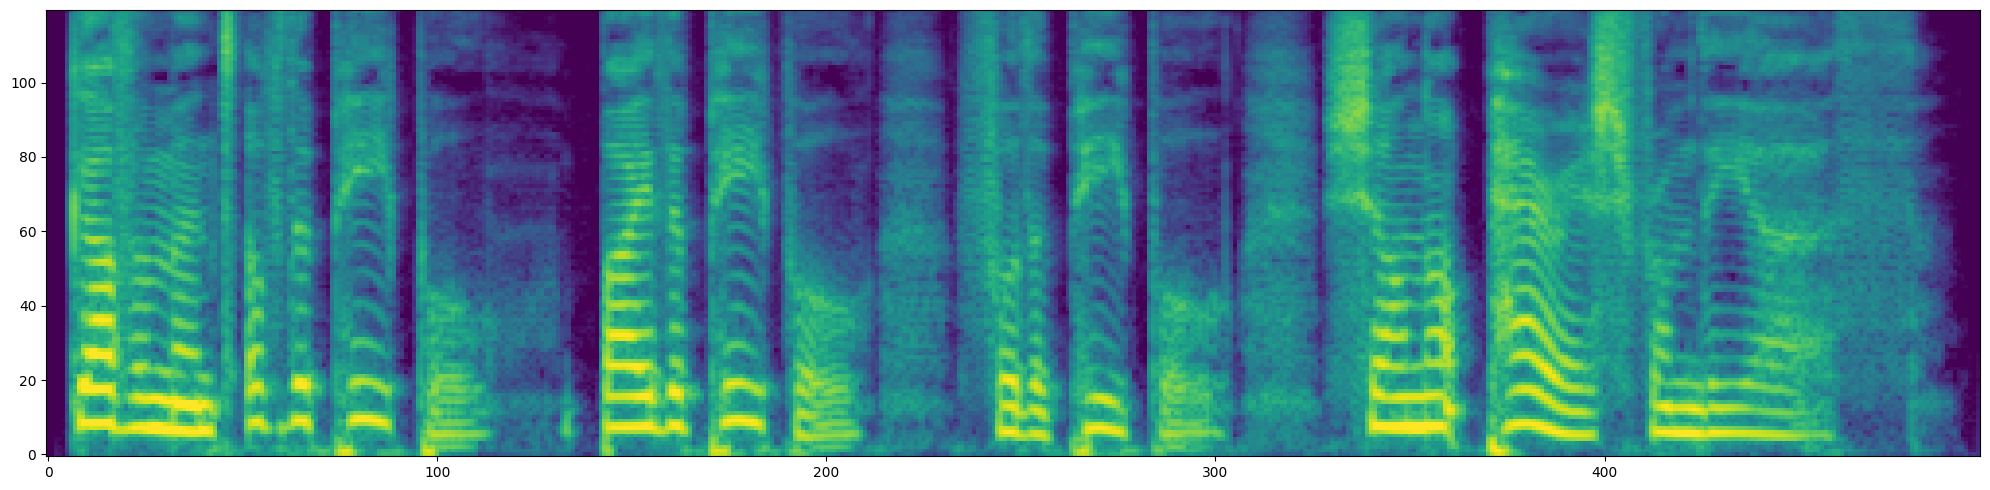

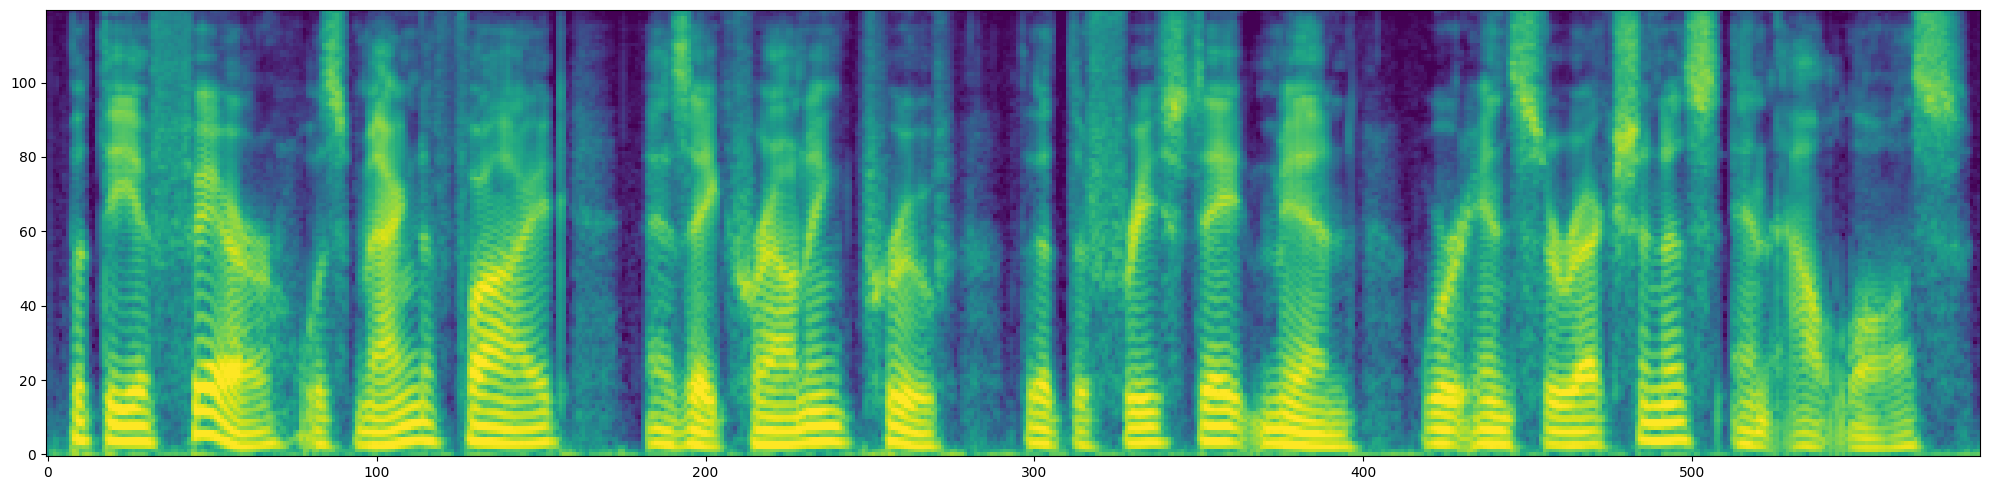

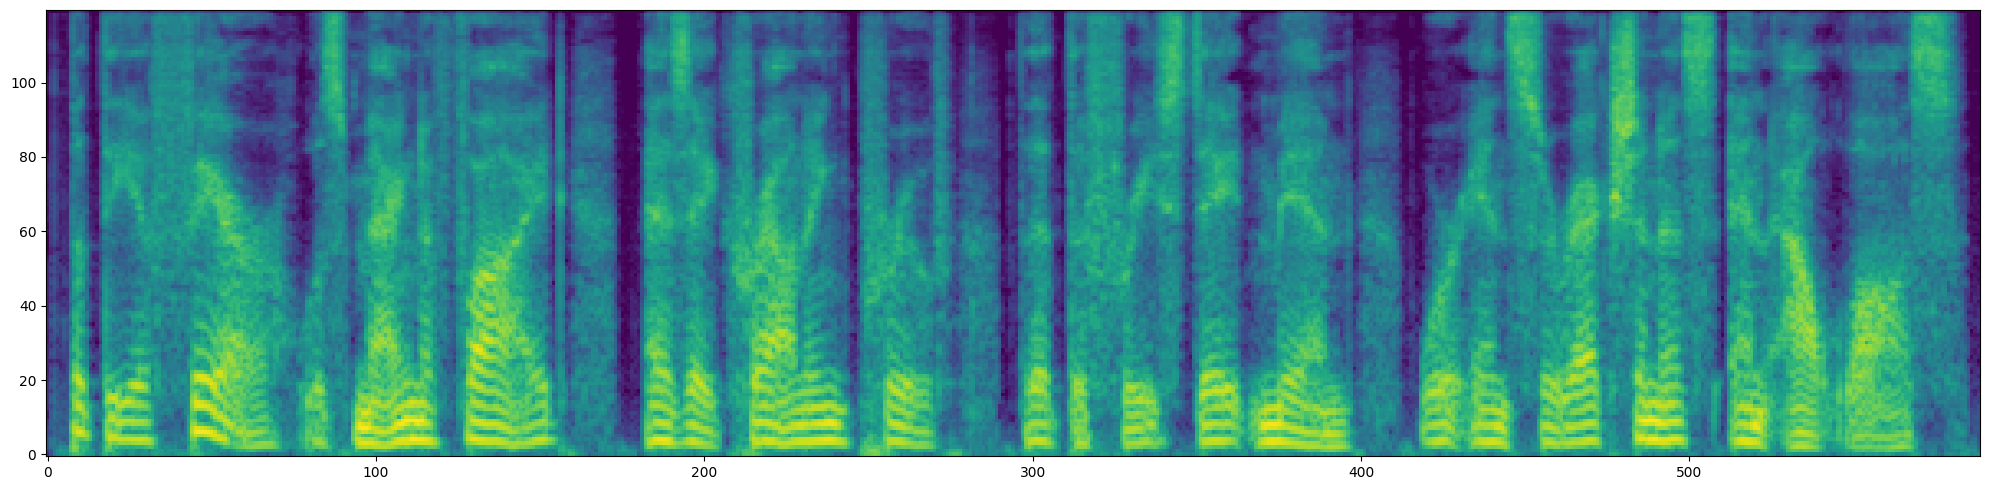

In [22]:
recon_wav = model.decode(prosody_code, cotent_code, None, target_style)
plot_debug(source_style)
plot_debug(source)
plot_debug(recon_wav)

In [20]:
vq_id = torch.cat([prosody_code, cotent_code, residual_code]).unsqueeze(1)

In [9]:
print(vq_id.shape)

torch.Size([6, 1, 589])
